In [6]:
import pandas as pd
import lightgbm as lgbm
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import datetime
from sklearn.metrics import f1_score
import warnings
from sklearn.model_selection import StratifiedKFold
import re

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
placeholder = 'abracadabra'

df = pd.read_csv("titanic3.csv", encoding='latin-1')

# the following COLs must be in the order that  they are in the CSV!
cols = ['pclass','sex','age','sibsp','parch','fare','cabin','embarked']
df_processed = []

vectorizers = []
i = 0


In [8]:
# this following cell does the text/pandas Object dtype processing into categorical variables
# transformed labels are kept in a CountVectorizer instance

# special columns that require different processing
special_cols = []
special_cols = []
numeric_cols = ['age', 'fare']
target_col = ['survived']

vect_input_cols = [x for x in cols if x not in special_cols]
vect_input_cols = [x for x in vect_input_cols if x not in numeric_cols]

cat_cols = vect_input_cols
df['boat'] = df['boat'].astype('str')
# vectorize the categorical text cols
for column in df:
    if df.columns[i] in vect_input_cols and 'Date' not in column and df.columns[i] not in target_col\
            and not is_numeric_dtype(df[column].dtype):
        
        foo = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
        # preprocess the text
        df[column] = df[column].replace(np.nan, placeholder, regex=True)
        df[column] = df[column].replace('NULL', placeholder, regex=True)
        df[column] = df[column].replace(' ', '', regex=True)
        df[column] = df[column].str.replace('[^\w]', '', regex=True)
        df[column] = df[column].str.lower()

        # grab the vectorized 1-tuples
        foo2 = foo.fit_transform(df[column]).indices.squeeze()
        df[column] = foo2.astype('int32')

        # switch the placeholder back with a nan
        na_placeholder = foo.transform([placeholder]).indices.squeeze()
        df[column] = df[column].replace(na_placeholder, np.nan, regex=True)
        df[column] = df[column].astype('category')
        
        print("Column " + column + " vocab size " + str(len(foo.vocabulary_)))

        vectorizers.append(foo)

        # df_processed.append(np.array(col))
    elif 'Date' in column:
        foo = CountVectorizer()
        df[column] = pd.DatetimeIndex(df[column]).month
        df[column] = df[column].astype('str')

        df[column] = df[column].replace(np.nan, placeholder, regex=True)
        df[column] = df[column].replace('NULL', placeholder, regex=True)

        df[column] = df[column].replace('^1$', 'jan', regex=True)
        df[column] = df[column].replace('^2$', 'feb', regex=True)
        df[column] = df[column].replace('^3$', 'mar', regex=True)
        df[column] = df[column].replace('^4$', 'apr', regex=True)
        df[column] = df[column].replace('^5$', 'may', regex=True)
        df[column] = df[column].replace('^6$', 'jun', regex=True)
        df[column] = df[column].replace('^7$', 'jul', regex=True)
        df[column] = df[column].replace('^8$', 'aug', regex=True)
        df[column] = df[column].replace('^9$', 'sep', regex=True)
        df[column] = df[column].replace('^10$', 'oct', regex=True)
        df[column] = df[column].replace('^11$', 'nov', regex=True)
        df[column] = df[column].replace('^12$', 'dec', regex=True)

        # grab the vectorized 1-tuples
        foo2 = foo.fit_transform(df[column]).indices.squeeze()
        df[column] = foo2.astype('int32')

        # switch the placeholder back with a nan
        na_placeholder = foo.transform([placeholder]).indices.squeeze()
        df[column] = df[column].replace(na_placeholder, np.nan, regex=True)
        df[column] = df[column].astype('category')

        vectorizers.append(foo)

    elif is_numeric_dtype(
            df[column].dtype
    ) and 'age' not in df.columns[i] and 'fare' not in df.columns[i]:
        df[column] = df[column].astype('category')
    
    i = i + 1



Column pclass vocab size 3
Column sex vocab size 2
Column sibsp vocab size 7
Column parch vocab size 8
Column cabin vocab size 187
Column embarked vocab size 4




FN rate: 0.2254 FP rate: 0.2941 Total Accuracy: 0.8015




FN rate: 0.1556 FP rate: 0.3418 Total Accuracy: 0.8168




FN rate: 0.2016 FP rate: 0.4459 Total Accuracy: 0.7748




FN rate: 0.2117 FP rate: 0.3521 Total Accuracy: 0.7939




FN rate: 0.1567 FP rate: 0.3418 Total Accuracy: 0.8161




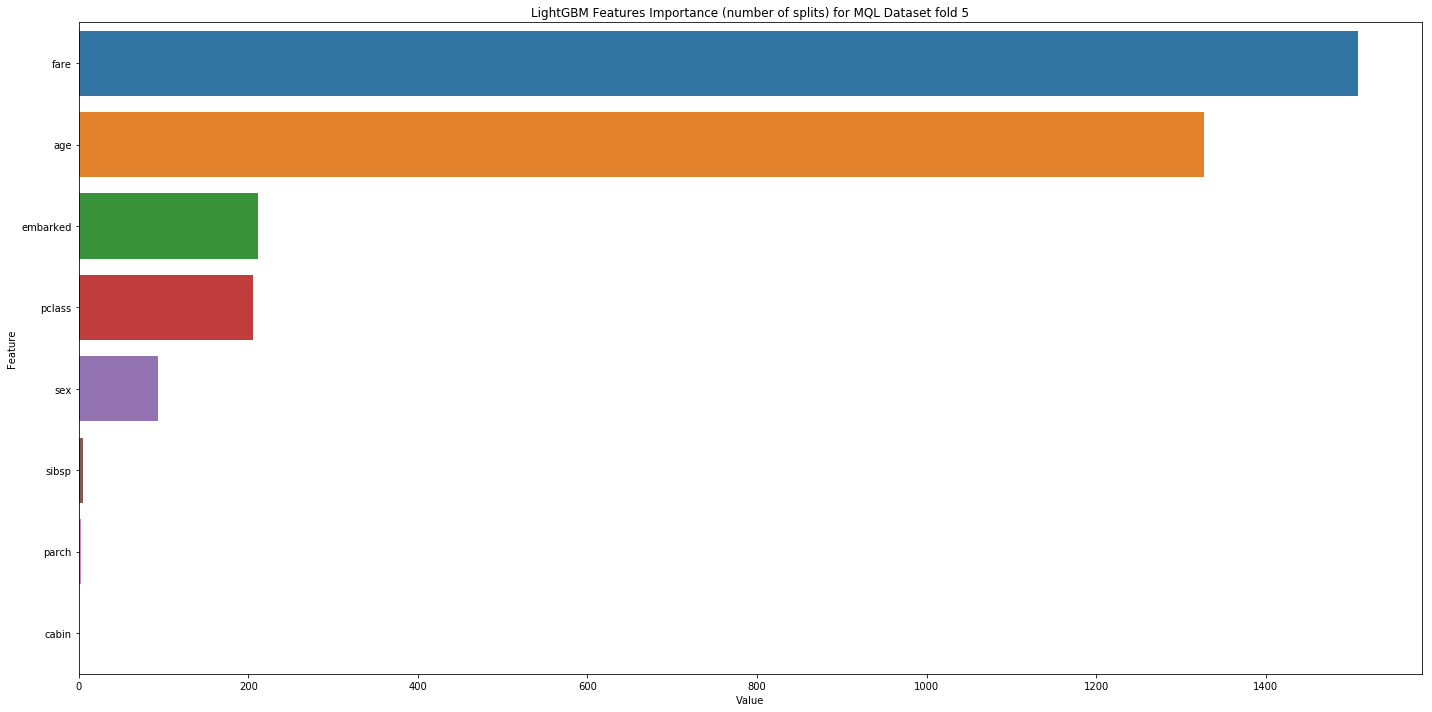



FN rate: 0.2113 FP rate: 0.2857 Total Accuracy: 0.8092




FN rate: 0.2197 FP rate: 0.4225 Total Accuracy: 0.7748




FN rate: 0.2158 FP rate: 0.3286 Total Accuracy: 0.7977




FN rate: 0.1515 FP rate: 0.3750 Total Accuracy: 0.8092




FN rate: 0.2180 FP rate: 0.3944 Total Accuracy: 0.7816




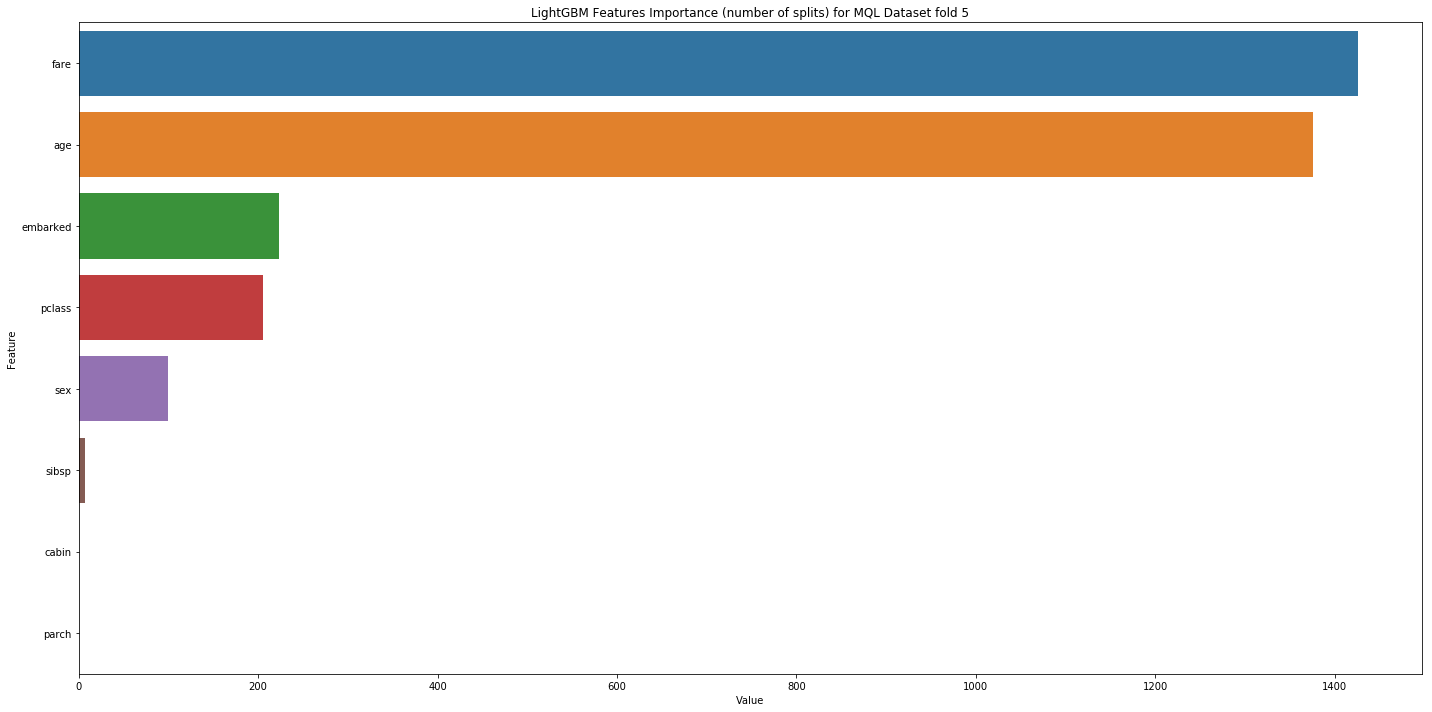



FN rate: 0.1544 FP rate: 0.3291 Total Accuracy: 0.8206




FN rate: 0.2448 FP rate: 0.2923 Total Accuracy: 0.7939




FN rate: 0.2308 FP rate: 0.4571 Total Accuracy: 0.7634




FN rate: 0.2286 FP rate: 0.3235 Total Accuracy: 0.7939




FN rate: 0.2029 FP rate: 0.3194 Total Accuracy: 0.8046




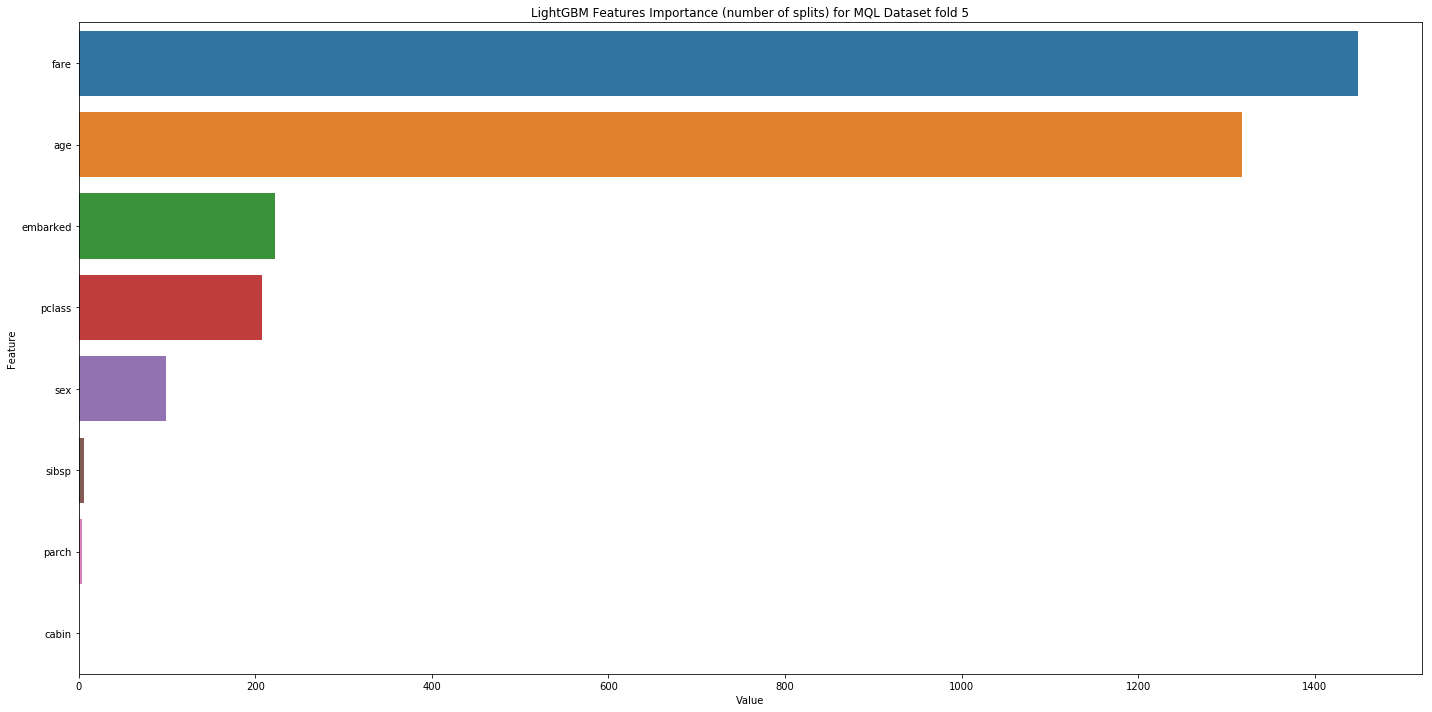

In [14]:
df[target_col] = df[target_col].astype('int64')
models = []
skf_overs = 3

for m in range(skf_overs):

    # stratified k-fold due to imbalance
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    split = 0

    X_train = None
    X_test = None
    Y_train = None
    Y_test = None

    model = None
    max_f1 = 0

    warnings.simplefilter(action='ignore', category=UserWarning)
    
    for train_index, test_index in skf.split(df[cols], df[target_col]):
        X_train, X_test = df[cols].iloc[train_index], df[cols].iloc[test_index]
        Y_train, Y_test = df[target_col].iloc[train_index], df[
            target_col].iloc[test_index]

        lgbm_train = lgbm.Dataset(X_train, Y_train)
        lgbm_eval = lgbm.Dataset(X_test, Y_test, reference=lgbm_train)

        params = {
            'objective': 'binary',
            'boosting': 'dart',
            'learning_rate': 0.1,
            'verbose': 1,
            'num_leaves': 546,
            'bagging_fraction': 0.8878,
            'bagging_freq': 1,
            'bagging_seed': 1,
            'feature_fraction': 0.9817,
            'feature_fraction_seed': 1,
            'max_bin': 8613,
            'num_rounds': 100,
            'max_depth': 23,
            'metric': 'auc',
            'is_unbalance': 'true',
            'verbose' : -1
        }

        # f1 score eval function
        def lgb_f1_score(y_hat, data):
            y_true = data.get_label()
            y_hat = np.round(y_hat)  # scikits f1 doesn't like probabilities
            return 'f1', f1_score(y_true, y_hat, average='macro'), True

        evals_result = {}

        # train model
        lgbm_model = lgbm.train(params,
                                train_set=lgbm_train,
                                valid_sets=lgbm_eval,
                                verbose_eval=-1,
                                feval=lgb_f1_score,
                                evals_result=evals_result,
                                categorical_feature=cat_cols,
                                early_stopping_rounds=2)

        # lgbm_model.save_model('lgbm_split' + str(split) + '.dat')
        models.append(lgbm_model)

        max_f1_temp = np.max(evals_result['valid_0']['f1'])

        if max_f1_temp > max_f1:
            max_f1 = max_f1_temp
            model = lgbm_model

        split = split + 1

        X_test = pd.DataFrame(X_test)
        X_test.columns = cols
        y_pred = []
        y_true = []

        # prediction sanity check
        for i in range(len(Y_test)):
            # print(X_test.iloc[i])
            foo = np.array(X_test.iloc[i]).reshape(-1, len(X_test.iloc[i]))
            foo2 = lgbm_model.predict(foo)
            #print("Predicted: %4.8f" % foo2, " truth: %4.8f" % Y_test.iloc[i])

            y_pred.append(float(foo2))
            y_true.append(float(Y_test.iloc[i]))

        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        from sklearn.metrics import confusion_matrix

        tr = 0.5

        def threshold(tr, temp):

            for i in range(len(temp)):
                if temp[i] < tr:
                    temp[i] = 0
                else:
                    temp[i] = 1

            return temp

        m = confusion_matrix(y_true, threshold(tr, y_pred))
        
        #print(m)
        fn = m[1][0] / m[0][0]
        fp = m[0][1] / m[1][1]
        print(
            "\n\nFN rate: %0.4f" % fn, "FP rate: %0.4f" % fp,
            "Total Accuracy: %0.4f\n\n" %
            (1 - (m[1][0] + m[0][1]) / np.sum(np.sum(m, 0))))

    warnings.simplefilter(action='ignore', category=FutureWarning)

    # LGBM features importance plot
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), cols)),
                               columns=['Value', 'Feature'])
    
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features Importance (number of splits) for MQL Dataset fold %d' % split)
    plt.tight_layout()
    plt.show(block = False )
    
    
    plt.pause(1)
    
    feature_imp = feature_imp.sort_values(by="Value", ascending=False)
    feature_imp_cols = list(feature_imp['Feature'].values)
    

The 'feature importance' plots above give some pretty interesting results, it seems that according to the highest accuracy model in a SKF split, 'fare' and 'age' are the 2 largest indicators of outcome. 

The accuracy metrics wrt to FP and FN rates are not the best (eg. we see a high incidence of FPs), but that is unfortunately a limitation of small sample sizes. The exercise is left up to the reader to see if they can improve this accuracy by hyperparameter tuning/search, or treshold adjustment.

Now let's see that the SHAP values say...

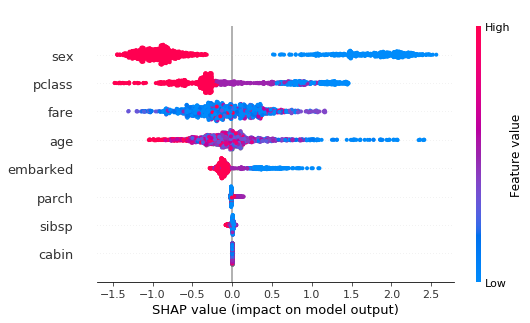

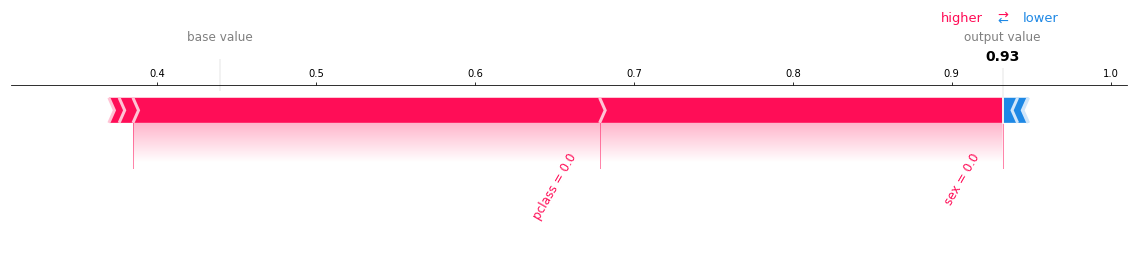

In [16]:
# SHAP inference
# RUN THIS CELL AGAIN TO GENERATE THE FACTOR ANALYSIS CSV FILES

warnings.simplefilter(action='ignore', category=RuntimeWarning)
    
import shap
from operator import itemgetter

# calculate Shapley values for the test set
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(df[cols])
shap_values_array = []
shap_values_array.append(shap_values)

baseline = explainer.expected_value

for i in range(1, len(models)):

    explainer = shap.TreeExplainer(models[i])
    temp = explainer.shap_values(df[cols])
    shap_values_array.append(temp)
    shap_values = shap_values + temp

shap_values = np.divide(shap_values, len(models))

shap_values_array = np.array(shap_values_array)

shap_values_df = pd.DataFrame(shap_values)
shap_values_df.index = df[cols].index
shap_avgs = []
shap_cols = ['factor', 'token', 'mean SHAP', 'stddev SHAP', 'count', '95% CI']

max_shap = 2.0

# grab the Shapley values corresponding to each unique factor in a column
# and do a reverse lookup from CountVectorizer
for i in range(len(vect_input_cols)):

    vect_values = [x for x in list(vectorizers[i].vocabulary_.values())]
    vect_keys = [x for x in list(vectorizers[i].vocabulary_.keys())]
    shap_avgs_col = []

    idx_col = cols.index(vect_input_cols[i])

    for j in range(len(vect_values)):
        idx = df[cols].loc[df[cols][vect_input_cols[i]] ==
                           vect_values[j]].index
        mean = []
        stddev = []

        for k in range(len(shap_values_array)):
            vals = []
            stddev_vals = []

            vals.append(shap_values_array[k][idx, idx_col])
            stddev_vals.append(shap_values_array[k][idx, idx_col])

            vals = np.array(vals).flatten()
            stddev_vals = np.array(stddev_vals).flatten()

            normalized_mean = []

            vals_it = 0
            for l in idx:
                numerator = np.exp(vals[vals_it])

                denominator = [np.exp(x) for x in shap_values_array[k][l]]
                denominator = np.array(denominator)
                denominator = np.sum(denominator)

                normalized_mean.append(
                    np.sign(vals[vals_it]) * numerator / denominator)

                vals_it = vals_it + 1

            normalized_mean = np.array(normalized_mean)
            mean.append(normalized_mean)

            normalized_stddev = []

            vals_it = 0
            for l in idx:
                numerator = np.exp(vals[vals_it])

                denominator = [np.exp(x) for x in shap_values_array[k][l]]
                denominator = np.array(denominator)
                denominator = np.sum(denominator)
                normalized_stddev.append(
                    np.sign(vals[vals_it]) * numerator / denominator)

                vals_it = vals_it + 1

            normalized_stddev = np.array(normalized_stddev)
            stddev.append(normalized_stddev)

        count = len(idx)

        shap_item = []

        shap_item.append(vect_keys[j])
        shap_item.append(vect_values[j])

        mean = np.array(mean).flatten()
        stddev = np.array(stddev).flatten()

        shap_item.append(np.mean(mean))
        shap_item.append(np.std(stddev))
        shap_item.append(count)

        shap_item.append(1.96 * np.std(stddev) / np.sqrt(count))

        shap_avgs_col.append(shap_item)

    shap_avgs_col = np.array(shap_avgs_col)
    shap_avgs_col = shap_avgs_col[np.argsort(shap_avgs_col[:, 2])]
    shap_avgs_col = pd.DataFrame(shap_avgs_col)
    shap_avgs_col.columns = shap_cols

    filename = vect_input_cols[i].replace(' ', '')
    filename = filename.replace('[^\w]', '')
    filename = filename.replace('/', '')
    filename = filename.lower()

    shap_avgs_col.to_csv(filename + '_titanic_shap.csv')

    #shap_avgs.append(shap_avgs_col)

# bin and calculate shapley values for numeric columns

shap_cols_numeric = ['value', 'mean SHAP', 'stddev SHAP', '95% CI']

for i in numeric_cols:
    shap_avgs_col = []
    idx_col = cols.index(i)
    shap_values_df[idx_col] = shap_values_df[idx_col].replace(np.nan, 0)

    for j in range(len(shap_values_df)):

        vals = []
        stddev_vals = []

        for k in range(len(shap_values_array)):
            vals.append(shap_values_array[k][:, idx_col][j])
            stddev_vals.append(shap_values_array[k][:, idx_col][j])

        vals = np.array(vals).flatten()
        stddev_vals = np.array(stddev_vals).flatten()

        normalized_mean = []

        for k in range(len(vals)):

            numerator = np.exp(vals[k])

            denominator = [np.exp(x) for x in shap_values_array[k][j]]
            denominator = np.array(denominator)
            denominator = np.sum(denominator)

            normalized_mean.append(np.sign(vals[k]) * numerator / denominator)

        normalized_mean = np.array(normalized_mean)
        mean = np.mean(normalized_mean)

        normalized_stddev = []

        for k in range(len(stddev_vals)):
            numerator = np.exp(vals[k])

            denominator = [np.exp(x) for x in shap_values_array[k][j]]
            denominator = np.array(denominator)
            denominator = np.sum(denominator)
            normalized_stddev.append(
                np.sign(vals[k]) * numerator / denominator)

        normalized_stddev = np.array(normalized_stddev)

        stddev = np.std(normalized_stddev)

        shap_item = []

        shap_item.append(df[i].iloc[j])

        shap_item.append(mean)
        shap_item.append(stddev)

        count = len(stddev_vals)

        shap_item.append(1.96 * stddev / np.sqrt(count))

        shap_avgs_col.append(shap_item)

    shap_avgs_col = np.array(shap_avgs_col)
    shap_avgs_col = shap_avgs_col[np.argsort(shap_avgs_col[:, 0])]
    shap_avgs_col = pd.DataFrame(shap_avgs_col)
    shap_avgs_col.columns = shap_cols_numeric

    filename = i.replace(' ', '')
    filename = filename.replace('[^\w]', '')
    filename = filename.replace('/', '')
    filename = filename.lower()

    shap_avgs_col.to_csv(filename + '_titanic_shap.csv')

# plot the Shapley values summary
shap.summary_plot(shap_values, df[cols])


# example 0 would be Ms. Elisabeth Walton Allen
# https://www.encyclopedia-titanica.org/titanic-survivor/elisabeth-walton-allen.html

example = 0

#shap.force_plot(explainer.expected_vashap.summary_plot(shap_values, df[cols])lue, shap_values, df[cols])
shap.force_plot(
    explainer.expected_value,
    shap_values[example, :],
    df[cols].iloc[example, :],
    matplotlib=True,
    text_rotation=60,
    link='logit',
)


In the above cell, the 1st plot - the SHAP value (impact on model output) plot - gives a different representation of 'feature importances'. The extreme spread along the x-axis and the polarity of the blue vs red dots indicates feature impact and the 'value' of a feature point respectively. In fact see we 'age' stands out as another highly influencial feature.

The 2nd plot analyzes the Shapley values for a particular example, and highlights the factors which contributed to the increase or decrease of the output value compared to the __baseline rate (31.97% of all passengers)__. Each of the factors in the 2nd plot are linearly additive on the baseline rate.

For a better analysis of the actual survival rates and a interesting discussion of the appearance of Simpson's Paradox when looking at aggregate statistics, check out: https://www.anesi.com/titanic.htm

The conlusion would be that if you were Female, of young age, and in 1st class, you had a much better chance of survival, which is more or less that happened in reality. This of course is only 'correlating' the apparant features to the outcomes. In reality, onboard the Titanic, 1st class passengers were closest to the lifeboats, and the 'women and children first' policy was implemented to preferentially place women and young passengers on the lifeboats.

It's interesting that the 'embarked' feature has somewhat of an influence, the conclusion is that there is possibly co-linearity or confounding with the other variables such as class or age, eg. in one location a majority of the 1st class passengers got on. It would be interesting to remove this variable and see the effect on output.